# Pneumonia Diagnosis using Lungs' XRays 

In [2]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
print(os.listdir("E:\\chest-xray-pneumonia\\chest_xray\\"))

['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [3]:
print(os.listdir("E:\\chest-xray-pneumonia\\chest_xray\\train\\"))

['NORMAL', 'PNEUMONIA']


In [4]:
TRAIN_DIR = "E:\\chest-xray-pneumonia\\chest_xray\\train\\"
TEST_DIR =  "E:\\chest-xray-pneumonia\\chest_xray\\test\\"

**Preprocessing**

In [5]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [6]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [7]:
# X_train, y_train = preprocessing_data(TRAIN_DIR)

In [8]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [9]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████████████████████████████████| 3875/3875 [21:07<00:00,  4.60it/s]


In [10]:
X_test , y_test = get_data(TEST_DIR)

100%|████████████████████████████████████████| 390/390 [01:41<00:00,  2.87it/s]


In [11]:
print(X_train.shape,'\n',X_test.shape)

(5216, 150, 150, 3) 
 (624, 150, 150, 3)


In [12]:
print(y_train.shape,'\n',y_test.shape)

(5216,) 
 (624,)


In [13]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Using TensorFlow backend.


**The arrays are not normalized because they have already been provided in the necessary format.**

In [14]:
print(y_train.shape,'\n',y_test.shape)

(5216, 2) 
 (624, 2)


In [15]:
Pimages = os.listdir(TRAIN_DIR + "PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")

In [16]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5):
    plotter(i)

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


<Figure size 1000x500 with 1 Axes>

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


<Figure size 1000x500 with 1 Axes>

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


<Figure size 1000x500 with 1 Axes>

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


<Figure size 1000x500 with 1 Axes>

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


<Figure size 1000x500 with 1 Axes>

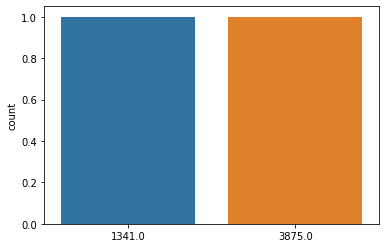

In [17]:
import seaborn as sns
count = y_train.sum(axis = 0)
sns.countplot(x = count)

**The classes are imbalanced therefore validation accuracy won't be a good metric to analyze the model performance , We will also have to take precision , recall and confusion matrix into account.**

In [18]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

C:\Users\piyush.lahoti\Anaconda3\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


**Callbacks to reduce learning rate timely after monitoring a quantity.**

In [19]:
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

**Making checkpoints timely to check and save the best model performance till last and also avoiding further validation accuracy drop due to overfitting.**

In [20]:
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [21]:
X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)

### Tried different model architectures , the best I could achieve was 83.75 % validation accuracy without any pre-trained CNN models. The architecture is different from the best and could give 83.01 %  . But again our main criteria is not accuracy but the precision and recall.

### Other Hyperparameters like learning rates, epochs, batch size , no. of filters , activation function have been tuned repeatedly to achieve better results.

In [22]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

print(model.summary())








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 75, 75)        9248      
__________________________________________________________

In [23]:
batch_size = 256
epochs = 6

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/6
5216/5216 [==============================] - ETA: 1:06:02 - loss: 0.6937 - acc: 0.45 - ETA: 42:49 - loss: 0.6916 - acc: 0.6016 - ETA: 35:39 - loss: 0.6900 - acc: 0.64 - ETA: 31:19 - loss: 0.6868 - acc: 0.68 - ETA: 36:54 - loss: 0.6847 - acc: 0.69 - ETA: 34:39 - loss: 0.6814 - acc: 0.70 - ETA: 33:11 - loss: 0.6769 - acc: 0.72 - ETA: 31:35 - loss: 0.6720 - acc: 0.72 - ETA: 30:54 - loss: 0.6673 - acc: 0.72 - ETA: 29:33 - loss: 0.6658 - acc: 0.72 - ETA: 28:16 - loss: 0.6590 - acc: 0.72 - ETA: 27:17 - loss: 0.6578 - acc: 0.72 - ETA: 26:44 - loss: 0.6528 - acc: 0.72 - ETA: 26:14 - loss: 0.6419 - acc: 0.73 - ETA: 25:34 - loss: 0.6435 - acc: 0.73 - ETA: 24:52 - loss: 0.6382 - acc: 0.73 - ETA: 24:50 - loss: 0.6326 - acc: 0.73 - ETA: 25:46 - loss: 0.6319 - acc: 0.73 - ETA: 25:33 - loss: 0.6317 - acc: 0.72 - ETA: 24:55 - loss: 0.6314 - acc: 0.72 - ETA: 24:21 - loss: 0.6263 - acc: 0.72 - ETA: 23:57 - loss: 0.6239 - acc: 0.72 - ETA: 23:53 - l

5216/5216 [==============================] - ETA: 13:56 - loss: 0.6757 - acc: 0.65 - ETA: 27:55 - loss: 0.5881 - acc: 0.71 - ETA: 28:40 - loss: 0.5722 - acc: 0.73 - ETA: 31:54 - loss: 0.5839 - acc: 0.72 - ETA: 29:12 - loss: 0.5784 - acc: 0.73 - ETA: 29:11 - loss: 0.5964 - acc: 0.70 - ETA: 31:00 - loss: 0.6066 - acc: 0.69 - ETA: 30:09 - loss: 0.5997 - acc: 0.70 - ETA: 29:52 - loss: 0.6023 - acc: 0.70 - ETA: 28:12 - loss: 0.5995 - acc: 0.70 - ETA: 26:29 - loss: 0.5915 - acc: 0.71 - ETA: 25:15 - loss: 0.5969 - acc: 0.71 - ETA: 24:03 - loss: 0.5932 - acc: 0.71 - ETA: 22:58 - loss: 0.5955 - acc: 0.71 - ETA: 22:12 - loss: 0.5891 - acc: 0.71 - ETA: 22:06 - loss: 0.5951 - acc: 0.70 - ETA: 25:17 - loss: 0.5941 - acc: 0.70 - ETA: 26:27 - loss: 0.5927 - acc: 0.70 - ETA: 27:05 - loss: 0.5896 - acc: 0.71 - ETA: 26:27 - loss: 0.5872 - acc: 0.71 - ETA: 26:23 - loss: 0.5838 - acc: 0.71 - ETA: 25:36 - loss: 0.5798 - acc: 0.71 - ETA: 24:44 - loss: 0.5752 - acc: 0.72 - ETA: 24:12 - loss: 0.5732 - acc: 0.

4544/5216 [=========================>....] - ETA: 12:26 - loss: 0.4266 - acc: 0.76 - ETA: 21:37 - loss: 0.3941 - acc: 0.81 - ETA: 25:17 - loss: 0.3960 - acc: 0.81 - ETA: 30:29 - loss: 0.4325 - acc: 0.80 - ETA: 28:43 - loss: 0.4371 - acc: 0.81 - ETA: 26:38 - loss: 0.4156 - acc: 0.83 - ETA: 24:42 - loss: 0.4158 - acc: 0.82 - ETA: 22:45 - loss: 0.4544 - acc: 0.81 - ETA: 22:22 - loss: 0.4542 - acc: 0.80 - ETA: 22:49 - loss: 0.4451 - acc: 0.82 - ETA: 22:36 - loss: 0.4406 - acc: 0.82 - ETA: 21:46 - loss: 0.4294 - acc: 0.82 - ETA: 21:09 - loss: 0.4303 - acc: 0.82 - ETA: 20:17 - loss: 0.4251 - acc: 0.82 - ETA: 19:43 - loss: 0.4338 - acc: 0.82 - ETA: 19:47 - loss: 0.4323 - acc: 0.82 - ETA: 19:01 - loss: 0.4263 - acc: 0.82 - ETA: 18:29 - loss: 0.4277 - acc: 0.82 - ETA: 17:56 - loss: 0.4271 - acc: 0.82 - ETA: 17:37 - loss: 0.4237 - acc: 0.82 - ETA: 17:11 - loss: 0.4158 - acc: 0.82 - ETA: 18:20 - loss: 0.4111 - acc: 0.82 - ETA: 18:00 - loss: 0.4096 - acc: 0.82 - ETA: 17:59 - loss: 0.4047 - acc: 0.

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**The model will try to overfit itself but rather save it prior going to the next epoch using necessary callbacks.**

**For better performance use exponential decaying learning rate and specify steps_per_epoch**

In [64]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

**Using mlxtend library for quick implementation of confusion matrix.**

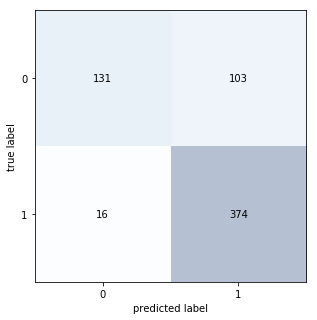

In [65]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

**Now, a model not good for validation accuracy might be actually good for precision or recall. So better tune according to the metric or your need.**

In [9]:
374 / (374 + 103)

0.7840670859538784

## Precision is of 78.40 % 

## Recall is of 95.89 % or approx. 96 % which is quite good. 

In [10]:
374 / (374 + 16)

0.958974358974359

### Here , recall is most significant quantity even more than accuracy and precision.  

###  Since we are having unequal number of people in both the classes , therefore we can't take accuracy as an alone metric to calculate model efficieny .

#### precision = True Positive / (True Positive + False Positive)

#### recall = True Positive / (True Positive + False Negative)

### Also precision can't be taken as alone metric and has less significance than recall in this particular dataset because we have to minimize false negative and that is in the denominator and thus finally increasing 'Recall' .  

### False negative has to be intuitively minimized because falsely diagnosing a patient of pneumonia as not having a pneumonia is a much larger deal than falsely diagnosing a healthy person as a pneumonia patient which is our major concern . That is why we are making this model . To reduce the mistakes done by doctors accidentally .

**-------------Data Science has always been much about context and intuition.--------------------------**